# Main Notebook to Perform Trading

### Imports

In [1]:
import matplotlib.pyplot as plt

from data_collection import get_sp500_sample, get_historical_data
from computing import compute_momentum, compute_mean_reversion, compute_signal_returns
from signals import generate_signals_momentum, generate_signals_meanreversion, generate_final_signal
from trading import build_strategy_choice_label, build_feature_matrix, track_strategy_chosen_signals
from training import train_strategy_chooser
from analysis import count_strategy_choices, build_trade_log, get_trades_for_stock
from risk_management import apply_stop_loss

### Get Data

In [2]:
# tickers = [
#     # Focus on Tech Company Stocks
#     "AAPL",  # Apple
#     "MSFT",  # Microsoft
#     "GOOG",  # Alphabet
#     "AMZN",  # Amazon
#     "META",  # Meta
#     "NVDA",  # NVIDIA
#     "IBM",   # IBM
#     "ORCL",  # Oracle
#     "INTC",  # Intel
#     "ADBE",  # Adobe
#     "CRM",   # Salesforce
#     "TSLA",  # Tesla

#     # Benchmark
#     "SPY"    # S&P 500
# ]

# Get a random sample of S&P 500 tickers
tickers = get_sp500_sample(n=15, seed=None)
tickers.append("SPY")


# Download historical data
start_date = "2015-01-01"
end_date = "2025-01-01"
data = get_historical_data(tickers, start=start_date, end=end_date)
spy_series = data["SPY"] # S&P 500

print("Historical Data Shape:", data.shape)
display(data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Historical Data Shape: (2516, 16)


,MCO,SBUX,WST,ECL,ROK,NKE,VST,AAPL,CDW,SLB,TFC,PWR,MDT,ENPH,FMC,SPY
Date,,,,,,,,,,,,,,,,
2024-12-24,480.380005,89.910004,332.769989,240.740005,292.200012,76.790001,143.360001,258.200012,176.339996,37.469128,43.990002,330.705322,80.840515,73.279999,49.144558,601.299988
2024-12-26,481.190002,91.860001,333.429993,239.360001,293.880005,76.940002,144.110001,259.019989,177.119995,37.469128,44.000000,330.515381,80.900002,73.010002,48.541859,601.340027
2024-12-27,476.760010,92.250000,333.220001,237.759995,290.500000,76.419998,139.679993,255.589996,175.809998,37.538647,43.669998,323.037781,80.739998,72.129997,48.423294,595.010010
2024-12-30,473.529999,90.580002,328.820007,234.520004,285.640015,74.650002,140.089996,252.199997,173.350006,37.548576,43.369999,318.879089,79.610001,70.190002,47.869999,588.219971
2024-12-31,473.369995,91.250000,327.559998,234.320007,285.790009,75.669998,137.869995,250.419998,174.039993,38.074913,43.380001,315.949982,79.879997,68.680000,48.610001,586.080017


### Compute Signals

In [3]:
# Compute Momentum & Mean-Reversion
momentum_df = compute_momentum(data, window=63)  # 3-month
zscore_df   = compute_mean_reversion(data, window=20)

In [4]:
# Generate separate signals
momentum_signals = generate_signals_momentum(momentum_df, threshold=0.10) # 10%
meanrev_signals = generate_signals_meanreversion(zscore_df, z_entry=1.0)

In [5]:
# Compute next-day returns from each approach
momentum_returns = compute_signal_returns(data, momentum_signals)
meanrev_returns = compute_signal_returns(data, meanrev_signals)
label = build_strategy_choice_label(momentum_returns, meanrev_returns)

### Train Model

In [6]:
# Build features & train the "strategy chooser"
features = build_feature_matrix(data, momentum_df, zscore_df, vol_window=20)
clf = train_strategy_chooser(features, label)

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.5127551020408163


### Results

In [7]:
# Generate the signals day by day based on classifier
signals = generate_final_signal(
    clf,
    features,
    momentum_signals,
    meanrev_signals
)

# Apply stop-loss to the signals
final_signals = apply_stop_loss(signals, data, 0.05)

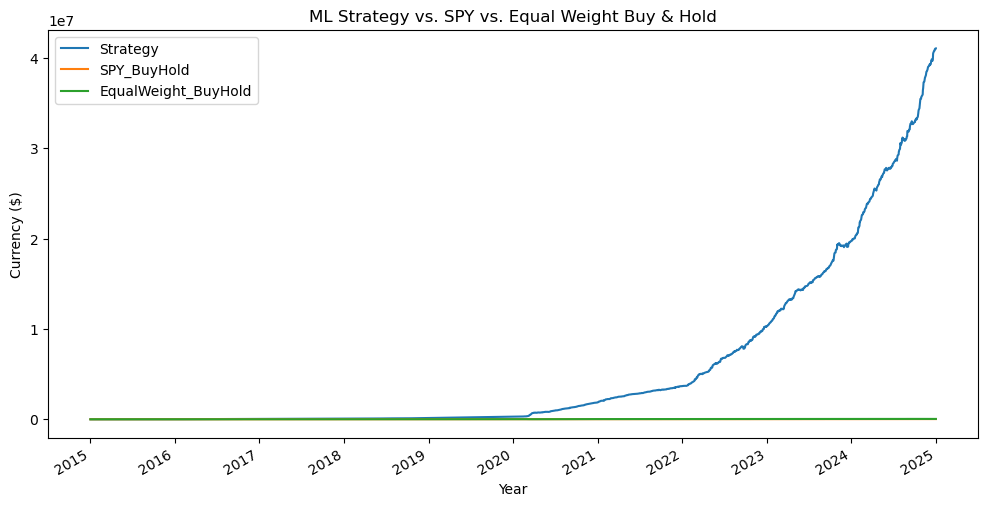

                Strategy   SPY_BuyHold  EqualWeight_BuyHold
Date                                                       
2024-12-24  4.079822e+07  34839.205453         51470.464151
2024-12-26  4.081505e+07  34841.525309         51549.812514
2024-12-27  4.098057e+07  34474.765338         51107.829359
2024-12-30  4.104008e+07  34081.351783         50471.763187
2024-12-31  4.104008e+07  33957.363283         50460.406732


In [8]:
# Track performance
result_df = track_strategy_chosen_signals(data, final_signals, spy_series)

# Plot all three equity curves
result_df[['Strategy', 'SPY_BuyHold', 'EqualWeight_BuyHold']].plot(
    figsize=(12, 6), title="ML Strategy vs. SPY vs. Equal Weight Buy & Hold"
)
plt.ylabel("Currency ($)")
plt.xlabel("Year")
plt.show()

print(result_df.tail())

### Testing and Analysis

In [9]:
n_mom, n_mr = count_strategy_choices(clf, features)

Momentum chosen:       912 days
Mean Reversion chosen: 283 days


In [10]:
trade_log = build_trade_log(final_signals, data)
print(trade_log.head(10))

        Date Ticker     Action       Price
0 2020-02-24   AAPL  OPEN_LONG   72.441597
1 2020-02-24    SPY  OPEN_LONG  298.923492
2 2020-02-24     BA  OPEN_LONG  317.899994
3 2020-02-24   SBUX  OPEN_LONG   76.311768
4 2020-02-24     GS  OPEN_LONG  198.675735
5 2020-02-24    JNJ  OPEN_LONG  127.821838
6 2020-02-24    DIS  OPEN_LONG  131.386887
7 2020-02-24    PEP  OPEN_LONG  123.541054
8 2020-02-24   INTC  OPEN_LONG   54.746277
9 2020-02-24   ORCL  OPEN_LONG   48.836918


Total trades for AAPL: 428

Showing the first 5 trades for AAPL:

          Date Ticker       Action      Price
0   2020-02-24   AAPL    OPEN_LONG  72.441597
24  2020-02-25   AAPL   CLOSE_LONG  69.987831
62  2020-04-02   AAPL   OPEN_SHORT  59.504719
84  2020-04-03   AAPL  CLOSE_SHORT  58.649555
110 2020-04-08   AAPL   OPEN_SHORT  64.640587


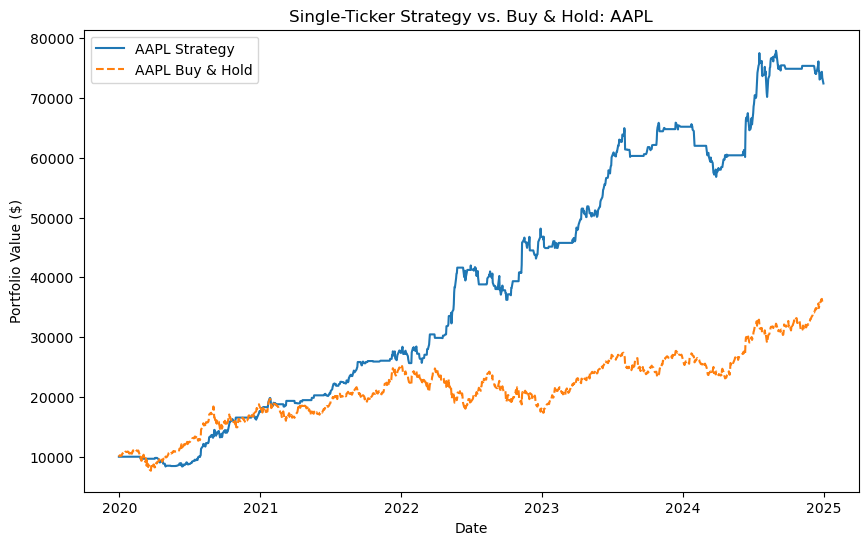

In [14]:
filtered_trades, equity, buyhold = get_trades_for_stock(
    trade_log_df=trade_log,
    final_signals=final_signals,
    price_data=data,
    ticker='AAPL', # Some good: MSFT, AAPL, Some bad: BA
    show_trade_count=5,
    initial_capital=10000.0
)